# EDSR

In [1]:
!pip install tensorflow-gpu==2.3.1 tensorflow-addons==0.11.2 ## replace to !pip install tensorflow for CPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 23 kB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
     |████████████████████████████████| 459 kB 62.0 MB/s 
     |████████████████████████████████| 2.9 MB 59.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      

In [2]:
!git clone https://github.com/IritaSee/super-resolution-colab.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 408 (delta 0), reused 2 (delta 0), pack-reused 405
Receiving objects: 100% (408/408), 48.16 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [3]:
%cd super-resolution

/content/super-resolution


In [4]:
!ls

article.ipynb  docs		   example-srgan.ipynb	model	   utils.py
data.py        environment.yml	   example-wdsr.ipynb	README.md
demo	       example-edsr.ipynb  LICENSE		train.py


In [5]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer

%matplotlib inline

In [6]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [7]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [ ]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [9]:
!wget https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz

--2022-07-13 20:43:27--  https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5653330 (5.4M) [application/gzip]
Saving to: ‘weights-edsr-16-x4.tar.gz’

weights-edsr-16-x4. 100%[===================>]   5.39M  3.13MB/s    in 1.7s    

2022-07-13 20:43:30 (3.13 MB/s) - ‘weights-edsr-16-x4.tar.gz’ saved [5653330/5653330]



In [10]:
! tar -xf weights-edsr-16-x4.tar.gz

In [11]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

In [ ]:
# # Train EDSR model for 300,000 steps and evaluate model
# # every 1000 steps on the first 10 images of the DIV2K
# # validation set. Save a checkpoint only if evaluation
# # PSNR has improved.
# # Uncomment codes below for training!
# trainer.train(train_ds,
#               valid_ds.take(10),
#               steps=300000, 
#               evaluate_every=1000, 
#               save_best_only=True)

In [12]:
# Restore from checkpoint with highest PSNR
trainer.restore()

In [13]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Validation (PSNR Score)

In [ ]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

PSNR = 5.943067


## Demo

In [14]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [16]:
from model import resolve_single
from utils import load_image
from PIL import Image
import numpy as np

def convert_and_plot(lr_image_path):
    lr = np.array(Image.open(lr_image_path).convert('RGB'))
    
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

In [17]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

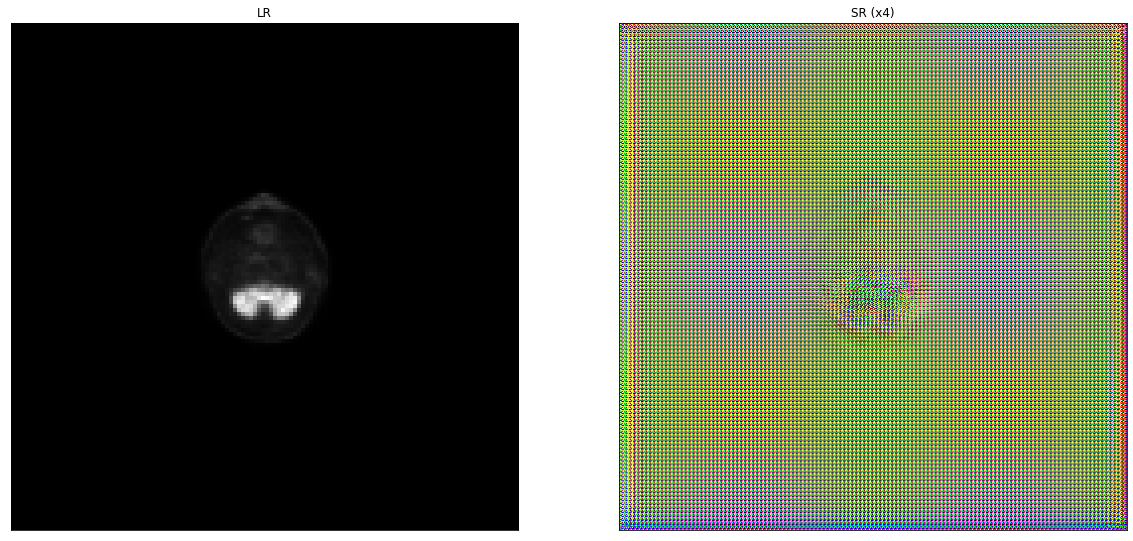

In [18]:
new_image = '/content/drive/MyDrive/super-resolution-master/new_dataset/PET-radiomics-challenges-kaggle/Test/1.3.6.1.4.1.14519.5.2.1.1707.8040.25195525414862185542009647.png'
convert_and_plot(new_image)

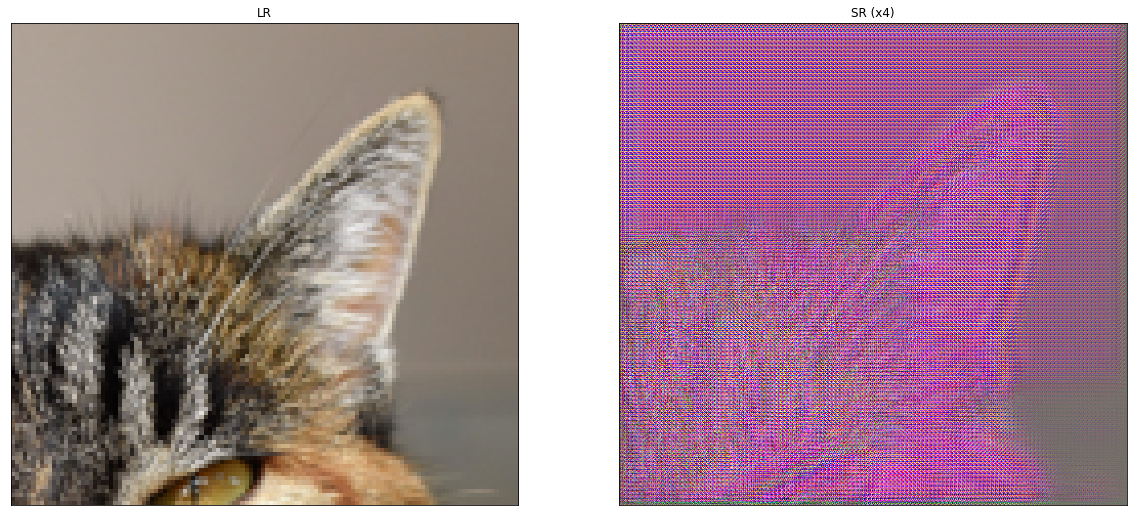

In [ ]:
resolve_and_plot('demo/0869x4-crop.png')

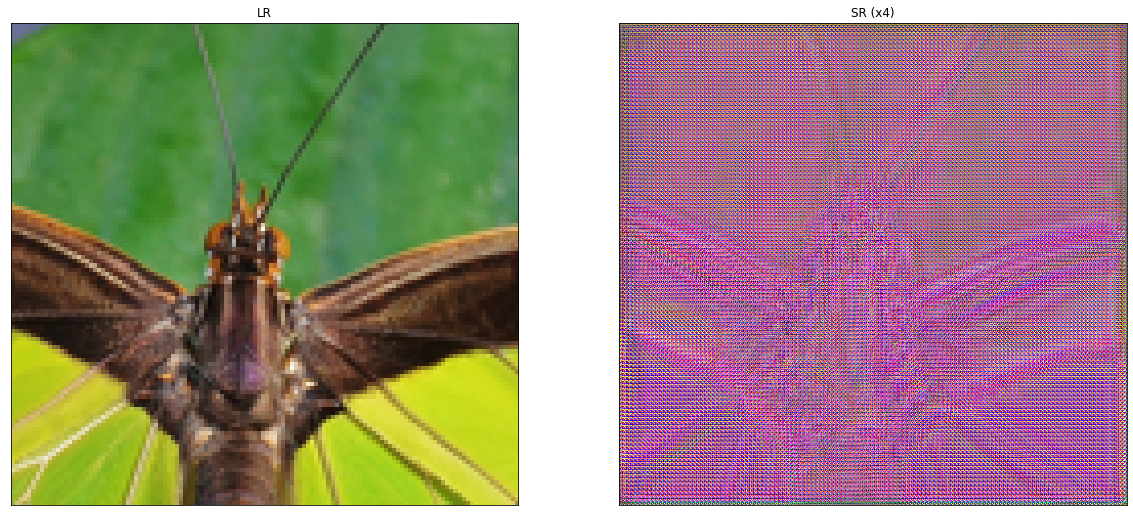

In [ ]:
resolve_and_plot('demo/0829x4-crop.png')

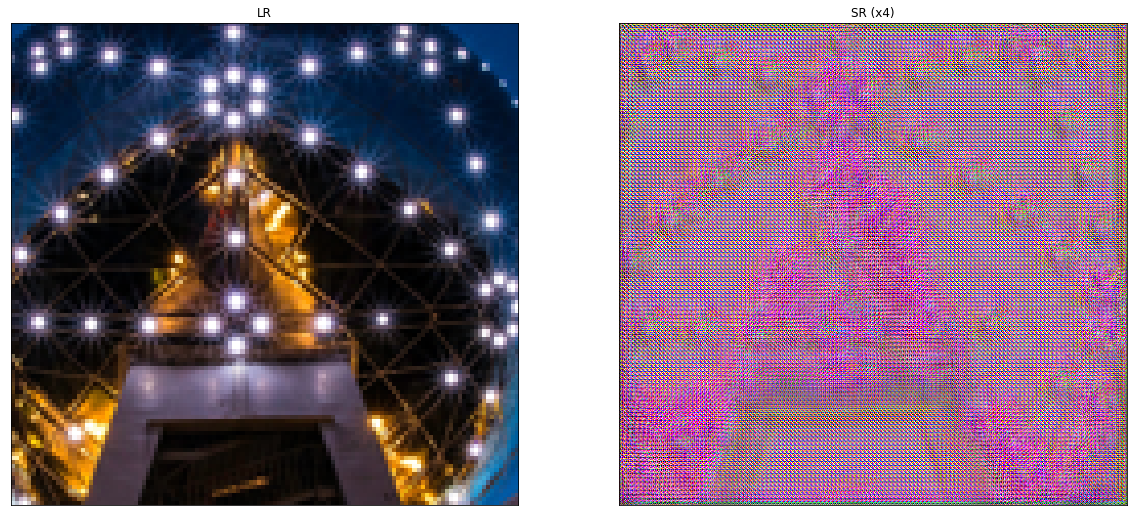

In [ ]:
resolve_and_plot('demo/0851x4-crop.png')